# CHAPTER 35: Particle Filters

### This code generates figure 4 from Chapter 35: Particle Filters (vol II)
TEXT: A. H. Sayed, INFERENCE AND LEARNING FROM DATA, Cambridge University Press, 2022.

<div style="text-align: justify">
DISCLAIMER:  This computer code is  provided  "as is"   without  any  guarantees.
Practitioners  should  use it  at their own risk.  While  the  codes in  the text 
are useful for instructional purposes, they are not intended to serve as examples 
of full-blown or optimized designs. The author has made no attempt at optimizing 
the codes, perfecting them, or even checking them for absolute accuracy. In order 
to keep the codes at a level  that is  easy to follow by students, the author has 
often chosen to  sacrifice  performance or even programming elegance in  lieu  of 
simplicity. Students can use the computer codes to run variations of the examples 
shown in the text. 
</div>

The Jupyter notebook and python codes are developed by Eduardo Faria Cabrera

required libraries:
    
1. numpy
2. matplotlib

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch

## Example 35.2 (Tracking a moving object in 2D)

We reconsider a variation of  Example 30.10. 
An object is moving in 2D, as shown in Fig. 35.3. We denote its coordinates at any instant $n$ by $\textnormal{col}\{a_{n},b_{n}\}$, where $a_{n}$ is the horizontal coordinate and $b_{n}$ is the vertical coordinate. The velocity components along the horizontal and vertical axes are denoted by $\textnormal{col}\{v_{a,n}, v_{b,n}\}$. Therefore, at any instant in time, the state of the object is described by the four-dimensional state vector $x_n=\textnormal{col}\{a_n,b_n,v_{a,n},v_{b,n}\}$. We assume this vector evolves according to the dynamics:

$$ 
\begin{bmatrix}
a_n\\
v_{a, n} \\
b_n \\
v_{b, n}
\end{bmatrix} = 
\begin{bmatrix}
1 & 1 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0  & 0  & 1 & 1  \\
0 & 0 & 0 & 1 
\end{bmatrix} \;\;\;
\begin{bmatrix}
a_{n-1}\\
v_{a, n-1} \\
b_{n-1} \\
v_{b, n-1}
\end{bmatrix} +
\begin{bmatrix}
0.5 & 0\\
1 & 0\\
0 & 0.5\\
0 & 1
\end{bmatrix} \;\;\;
\begin{bmatrix}
u_{a, n}\\
v_{b, n}
\end{bmatrix} \tag{35.60}
$$

where the perturbation $u_n\sim{\cal N}_{u_n}(0,\sigma_{u}^2 I_2)$. The observations are noisy measurements of the angle viewed from an observer at the origin, i.e.,

$$
y_n = \arctan(b_n/a_n)+ {\cal N}_{v}(0,\sigma_v^2) \tag{35.61}
$$

In [106]:
M = 4 # state dimension
N = 100 # time horizon
J = 5000 # number of particles

w = (1/J)*np.ones(J) # initial parameters

# x0 ~ N(x0_bar, Pi_0); initial state vector
x0_bar = np.array([ #mean
    [0], [0], [0.4], [-0.05]
])

Pi_0 = np.eye(M) #initial state covariance
Pi_0[0, 0] = 0.25
Pi_0[1, 1] = 25E-6
Pi_0[2, 2] = 0.09
Pi_0[3, 3] = 1E-4

#State-space model
F = np.array([
    [1, 1, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 1],
    [0, 0, 0, 1]
])

G = np.array([
    [0.5, 0],
    [1, 0],
    [0, 0.5],
    [0, 1]
])
var_u = 1E-6
var_v = 25E-6

#generate data
x0 = np.array([
    [-0.05], [0.001], [0.7], [-0.055]
])
xvec = np.zeros((M, N)) # x1 to xN
yvec = np.zeros(N) #y1 yo yN
uvec = np.sqrt(var_u)*np.random.randn(2, N)
vvec = np.sqrt(var_v)*(np.random.rand(N))
xpast = x0

for n in range(N):
    xvec[:, n] = (F@xpast).T + G@uvec[:, n]
    a = xvec[0, n]
    b = xvec[2, n]
    yvec[n] = np.arctan(b/a) + vvec[n]
    xpast = xvec[:, n]

# Boostrap particle filter
x0J = np.zeros((M, J))
for j in range(J):
    x0J[:, j] = (x0_bar + np.sqrt(Pi_0)@np.random.randn(M, 1)).reshape(-1) # sampling J initial conditions
    w[j] = 1/J

xminusJ = np.zeros((M, J)) #x_{n-1}^j particles and weights
xminusJ = x0J
xnJ = np.zeros((M, J))

trajectoriesCell = [] # cumulative trajectories for all particles
auxtrajectories = J*[[]]

for j in range(J):
    trajectoriesCell.append(x0J[:, j].reshape(-1, 1))

for n in range(N):
    y = yvec[n]

    for j in range(J):
        xnJ[:, j] = (F@xminusJ[:, j].reshape(-1, 1) + G@(np.sqrt(var_u)*np.random.randn(2, 1))).reshape(-1) #sampling
        aux22 = trajectoriesCell[j]
        trajectoriesCell[j] = np.concatenate([aux22, (xnJ[:, j]).reshape(-1, 1)], axis=-1)
        a = xnJ[0, j]
        b = xnJ[2, j]
        w[j] = np.exp(-(0.5/var_v)*(y-np.arctan(b/a))**2)
    xminusJ = xnJ
    w = w/sum(w)

    z = np.cumsum(w)
    z = np.insert(z, 0, 0)
    for j in range(J): #resampling
        x = np.random.rand() # a random number between 0 and 1
        yy = np.argwhere(z<=x) # find all entries smaller than x
        m = yy.max() # largest index determines sample chosen
        if m == M+1:
            m = M
        auxtrajectories[j] = trajectoriesCell[m]
    
    for j in range(J):
        trajectoriesCell[j] = auxtrajectories[j]

w = (1/J)*np.ones(J)

# estimated trajectory
av_trajectory = np.zeros((M, N+1)) # from 0 to N
for j in range(J):
    av_trajectory = av_trajectory + trajectoriesCell[j]
av_trajectory = av_trajectory/J

avec = np.zeros(N+1)
bvec = np.zeros(N+1)
avec[0] = x0[0, 0]
bvec[0] = x0[2, 0]
avec[1:] = xvec[0, :]
bvec[1:] = xvec[2, :]

avec_hat_boostrap = av_trajectory[0, :]
bvec_hat_boostrap = av_trajectory[2, :]

In [107]:
# Auxiliary particle filter

xminusJ = np.zeros((M, J)) #x_{n-1}^j particles and weights
xminusJ = x0J
xnJ = np.zeros((M, J)) #x_n^j particles
w = (1/J)*np.ones(J)

trajectoriesCell = [] # cumulative trajectories for all particles
trajectoriesStar = J*[[]]

for j in range(J):
    trajectoriesCell.append(x0J[:, j].reshape(-1, 1))

s = np.zeros((M, J))
for n in range(N):
    y = yvec[n]
    for j in range(J):
        s[:, j] = F@xminusJ[:, j] # mean based on prior state
    
    for j in range(J):
        a = s[0, j]
        b = s[2, j]
        w[j] = w[j]*np.exp(-(0.5/var_v)*(y-np.arctan(b/a))**2) # scaling
    w = w/sum(w) # normalization

    z = np.cumsum(w) # resampling
    z = np.insert(z, 0, 0)
    for j in range(J):
        x = np.random.rand() # random number between 0 and 1
        yy = np.argwhere(z<=x) #find all entries smaller than x
        m = yy.max()
        if m == M+1:
            m = M
        trajectoriesStar[j] = trajectoriesCell[m]
        w[j] = 1/J

    auxJ = np.zeros((M, J))
    for j in range(J):
        xx = trajectoriesStar[j] #j-th particle is a trajectory
        auxJ[:, j] = xx[:, n] # most recent state added to the trajectory

    sminus = np.zeros((M, J))
    for j in range(J):
        sminus[:, j] = F@auxJ[:, j] # mean based on prior state
    
    for j in range(J):
        xnJ[:, j] = (F@auxJ[:, j].reshape(-1, 1) + G@(np.sqrt(var_u)*np.random.randn(2, 1))).reshape(-1) #sampling to update state
        aux22 = trajectoriesStar[j]
        trajectoriesStar[j] = np.concatenate([aux22, (xnJ[:, j]).reshape(-1, 1)], axis=-1) # augment the trajectory
    
    xminusJ = xnJ

    for j in range(J):
        a = xnJ[0, j]
        b = xnJ[2, j]
        c = -(0.5/var_v)*(y-np.arctan(b/a))**2
        if c <= -20: #avoid large exponents
            w1 = 1E-9
        else:
            w1 = np.exp(c)
        a2 = sminus[0, j]
        b2 = sminus[2, j]
        c2 = -(0.5/var_v)*(y-np.arctan(b2/a2))**2
        if c2 <= -20: #avoid large exponents
            w2 = 1E-9
        else:
            w2 = np.exp(c2)
        w[j] = w1/w2
    w = w/sum(w)

    for j in range(J):
        trajectoriesCell[j] = trajectoriesStar[j]

# estimated trajectory
av_trajectory = np.zeros((M, N+1)) # from 0 to N
for j in range(J):
    av_trajectory = av_trajectory + trajectoriesCell[j]
av_trajectory = av_trajectory/J

avec_hat_auxiliary = av_trajectory[0, :]
bvec_hat_auxiliary = av_trajectory[2, :]

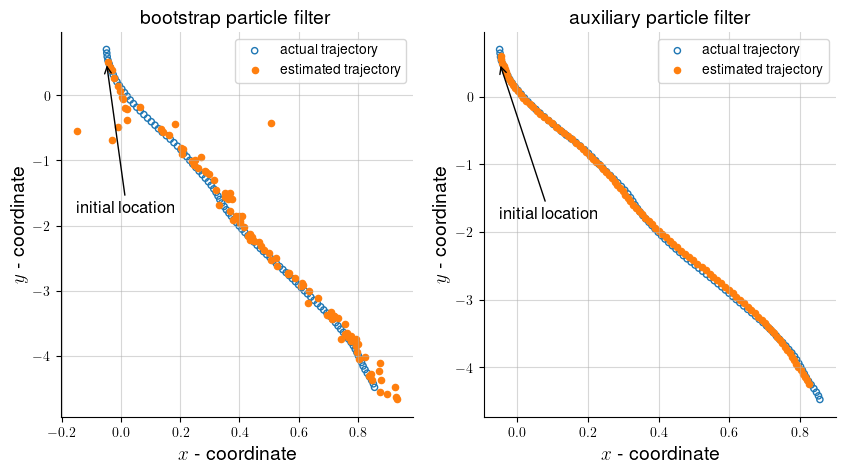

In [123]:
#figure 4 (comparison)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.rcParams['figure.figsize']=10, 5
fig = plt.figure()

ax = fig.add_subplot(121)
ax.scatter(avec, bvec, label="actual trajectory", s=20, facecolors="none", edgecolors="tab:blue")
ax.scatter(avec_hat_boostrap, bvec_hat_boostrap, label="estimated trajectory", s=20, color="tab:orange")
ax.set_xlabel("$x$ - coordinate", fontsize=14)
ax.set_ylabel("$y$ - coordinate", fontsize=14)
ax.set_title("bootstrap particle filter", fontsize=14)
ax.spines[['right', 'top']].set_visible(False)
plt.grid(zorder=0, alpha=0.5)
ax.annotate("initial location", xy=(avec[0], bvec[0]-0.2), xytext=(avec[0]-0.1, bvec[0]-2.5), arrowprops=dict(arrowstyle="->", connectionstyle="arc3"), fontsize=12, fontweight='bold')
plt.legend()

ax = fig.add_subplot(122)
ax.scatter(avec, bvec,label="actual trajectory", s=20, facecolors="none", edgecolors="tab:blue")
ax.scatter(avec_hat_auxiliary, bvec_hat_auxiliary, label="estimated trajectory", s=20, color="tab:orange")
ax.set_xlabel("$x$ - coordinate", fontsize=14)
ax.set_ylabel("$y$ - coordinate", fontsize=14)
ax.set_title("auxiliary particle filter", fontsize=14)
plt.grid(zorder=0, alpha=0.5)
ax.spines[['right', 'top']].set_visible(False)
ax.annotate("initial location", xy=(avec[0], bvec[0]-0.2), xytext=(avec[0], bvec[0]-2.5), arrowprops=dict(arrowstyle="->", connectionstyle="arc3"), fontsize=12, fontweight='bold')
plt.legend()

plt.savefig("figs/fig-4.pdf", format="pdf", bbox_inches="tight")

plt.show()

**Figure 35.4** A moving object in 2D; its coordinates are denoted by $(a_n,b_n)$ at time $n$; the speed components along the horizontal and vertical axes are denoted by $(v_{a,n},v_{b,n})$. The bearing $\theta_n$ is the angle viewed from the origin. 

The initial state is Gaussian-distributed with 

$$
x_0\sim{\cal N}_{x_0}(\bar{x}_0,\Pi_0),\;\;\;
\bar{x}_0=\begin{bmatrix}
0 \\ 0 \\ 0.4 \\ -0.05
\end{bmatrix}\;\;\;
\Pi_0=\begin{bmatrix}
0.25 & & & \\
& 25 \times 10^{-6} & & \\
& & 0.09 & \\
& & & 10^{-4} 
\end{bmatrix} \tag{35.62}
$$

 We assume the numerical values

$$
\sigma_u^2 = 1\times 10^{-6},\;\;\;\;\;\sigma_{v}^2=25\times 10^{-6} \tag{35.63}
$$

The actual trajectory is generated in the simulation by starting from the initial state vector

$$
x_0=\textnormal{col}\{-0.05, 0.001, 0.7, -0.055\} \tag{35.64}
$$

Figure 35.4 shows the actual and estimated trajectories using $J=5000$ particles and the boosting and auxiliary particle filters applied to model (35.60)--(35.61) over $0\leq n\leq 100$. The auxiliary variables $s_n^j$ are computed by using $s_n^j = F x_{n-1}^j$.